# Single Cell analisys of Mus musculus limb muscle tissue

Data obtained from: https://datasets.cellxgene.cziscience.com/8efaf5ba-9121-451a-a4d4-d63add2404d8.h5ad

### Import necessary libraries

In [1]:
import scanpy as sc
import pandas as pd
import anndata as ad
from scipy.io import mmread

### Load data into an AnnData object

In [2]:
adata = sc.read('limbmuscle_sc.h5ad')  # Read the reduced AnnData 
adata.var_names_make_unique()
adata.var_names = adata.var_names.astype(str)  # Convert to string if categorical

In [3]:
adata.var_names = adata.var['feature_name']
print(sorted(adata.var_names.tolist()))

['0610005C13Rik', '0610009B22Rik', '0610009L18Rik', '0610010K14Rik', '0610030E20Rik', '0610031O16Rik', '0610038B21Rik', '0610039K10Rik', '0610040B10Rik', '0610040F04Rik', '0610040J01Rik', '0610043K17Rik', '1110002L01Rik', '1110004F10Rik', '1110006O24Rik', '1110015O18Rik', '1110017D15Rik', '1110019D14Rik', '1110020A21Rik', '1110028F11Rik', '1110028F18Rik', '1110032F04Rik', '1110038B12Rik', '1110038F14Rik', '1110046J04Rik', '1110059E24Rik', '1110059G10Rik', '1110065P20Rik', '1190005I06Rik', '1300002E11Rik', '1500004A13Rik', '1500009L16Rik', '1500011B03Rik', '1500012K07Rik', '1500015A07Rik', '1500015L24Rik', '1600010M07Rik', '1600012H06Rik', '1600014C10Rik', '1600014C23Rik', '1600020E01Rik', '1600025M17Rik', '1600029O15Rik', '1700001C19Rik', '1700001D01Rik', '1700001F09Rik', '1700001G11Rik', '1700001G17Rik', '1700001J03Rik', '1700001J11Rik', '1700001K19Rik', '1700001L05Rik', '1700001O22Rik', '1700001P01Rik', '1700003C15Rik', '1700003D09Rik', '1700003E16Rik', '1700003F12Rik', '1700003G18Ri

/home/albert-turon/anaconda3/lib/python3.12/site-packages/anndata/_core/anndata.py:844: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['Rsrc2', 'Tmem121', 'Ube3b', 'Rnf167', 'Snx13']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


## Quality Control
### Calculate percentage of mitochondrial genes to check quality of our data

In [4]:
# mitochondrial genes start with "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("Mt")

In [5]:
#Calculates metrics such as total_counts, nº of genes by counts and % of mitochondrial counts
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, log1p=True)


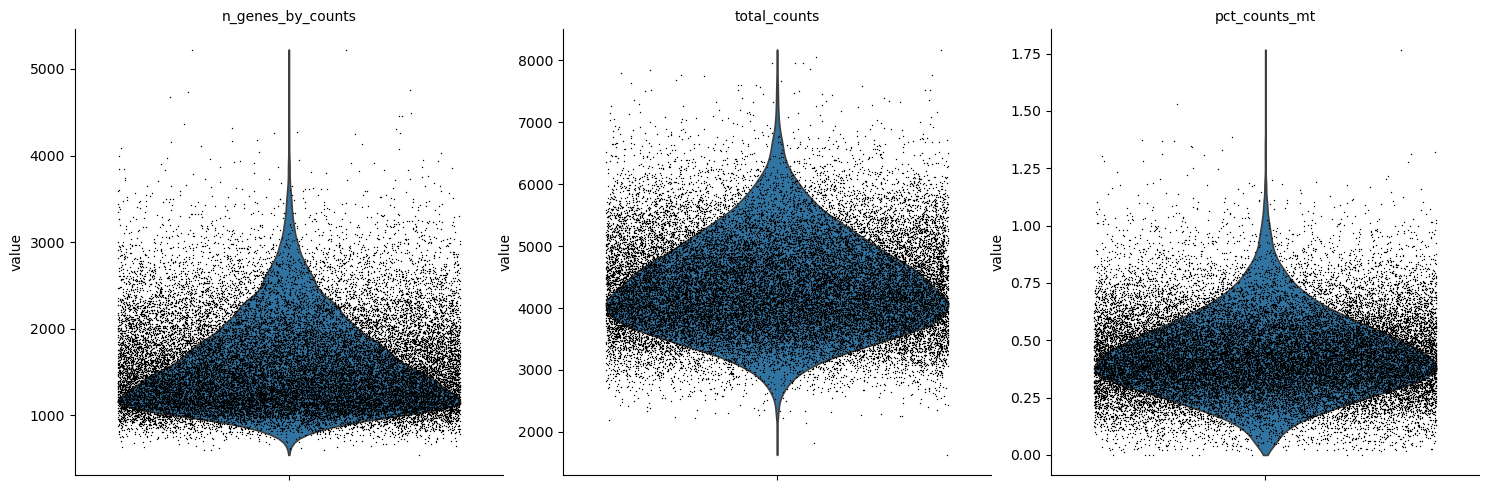

In [6]:
# Violin plots to visualize the quality of our data
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

By observing this plots we can say that our data has a high quality as the majority of cells have more than 3000 counts and there arent many high count cells which would indicate the presence of doublets. Moreover, we can see there is an average of more than 1000 genes by count.

The average percentage of mitochondrial gene counts is well below 1% indicating that our data doesn't contain many damaged cells and has a high quality.

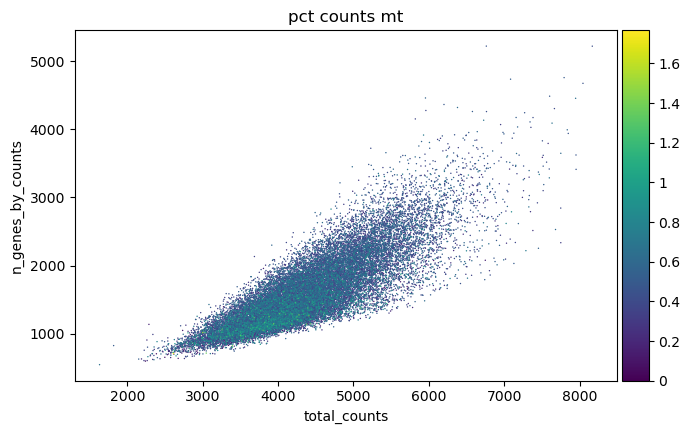

In [7]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

### Filtering

If our data has low quality we can filter cells that have a high percentage of mithocondrial gene counts, cells that have a low number of genes and/or genes that are only expressed in a few cells.

In our case the quality of our data is quite high so it is not really necessary to perform this step

In [8]:
sc.pp.filter_cells(adata, min_genes=100) # filters cells that have a low number of counts (expressed genes)
sc.pp.filter_genes(adata, min_cells=10) # filters genes that are expressed in less than 10 cells

We can further filter our data by using a scanpy function to detect and remove doublets

In [9]:
sc.pp.scrublet(adata, batch_key="age", n_prin_comps=25)

## Clustering

We save the raw data in a layer of the AnnData object named "counts". This way we can transform the data without risk of losing our original data.

In [10]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

### Transforming our data and calculating PCs
We normalize our data and calculate the highly variable genes to be able to clusterize our cells later on

In [11]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

In [12]:
adata.obs["age"] = adata.obs["age"].astype("category") # Transform age column into a category to use it as groups
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="age") # Calculate the highly variable genes

In [13]:
# We can check if the gene we are interested in is highly variable
if 'Myod1' in adata.var_names:
    is_highly_variable = adata.var.loc['Myod1', 'highly_variable']
    print(f"Is Myod1 highly variable? {is_highly_variable}")

Is Myod1 highly variable? False


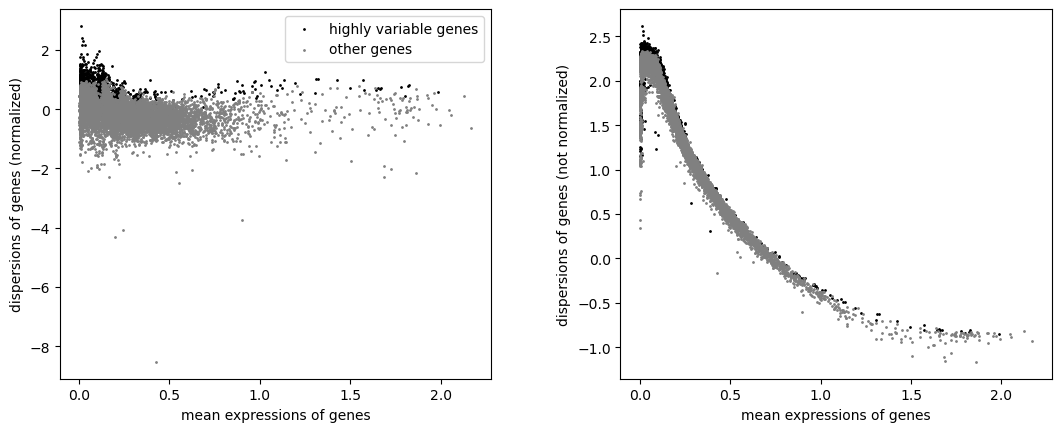

In [14]:
# Elbow graphs showing the distributions of the highly variable genes
sc.pl.highly_variable_genes(adata)

We perform a principal component analisys (pca) to reduce the dimensionality of our data while preserving the most significant sources of variance.

In [15]:
sc.tl.pca(adata)

We can plot the variance ratio of each principal component (pc) to better understand how much variance is described by each pc.

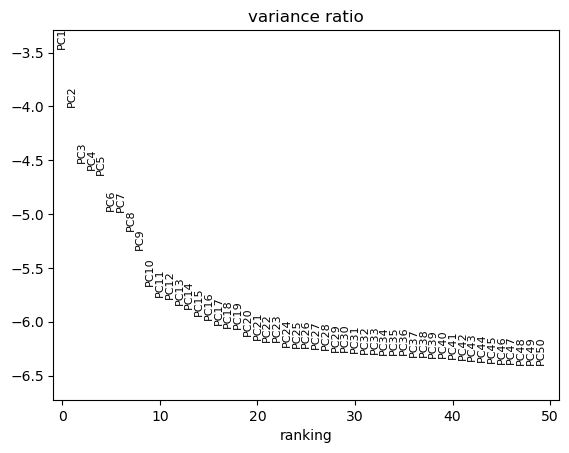

In [16]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

### Calculating neighbors and clustering the data

In [17]:
sc.pp.neighbors(adata)

In [18]:
sc.tl.umap(adata)

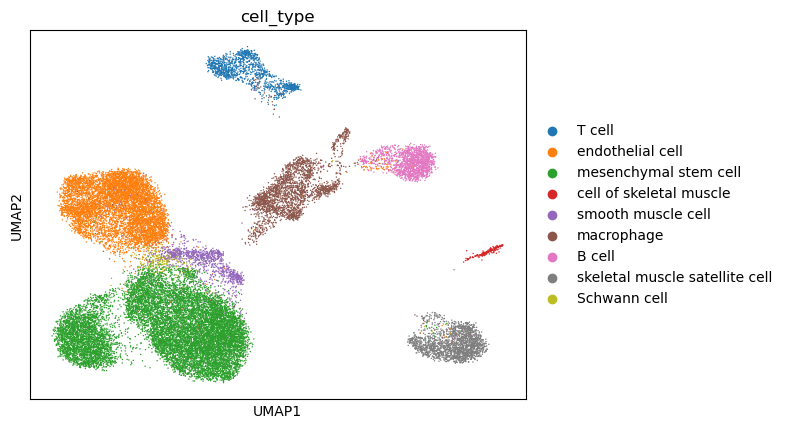

In [19]:
sc.pl.umap(
    adata,
    color="cell_type",
)

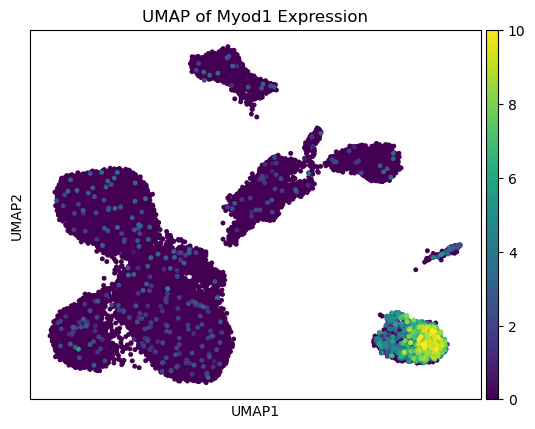

In [20]:
# Extract the expression values of 'Myod1' from the 'counts' layer
myod1_counts = adata.layers["counts"][:, adata.var_names.get_loc("Myod1")].toarray().flatten()

# Add Myod1 expression from raw counts to adata.obs for plotting
adata.obs["Myod1_raw"] = myod1_counts

# Plot UMAP with Myod1 expression from raw counts
sc.pl.umap(
    adata, 
    color="Myod1_raw",
    size=50,
    vmin=0,
    vmax=10,
    title="UMAP of Myod1 Expression"
)


In [21]:
# Using the igraph implementation and a fixed number of iterations can be significantly faster, especially for larger datasets
sc.tl.leiden(adata, flavor="igraph", n_iterations=2)

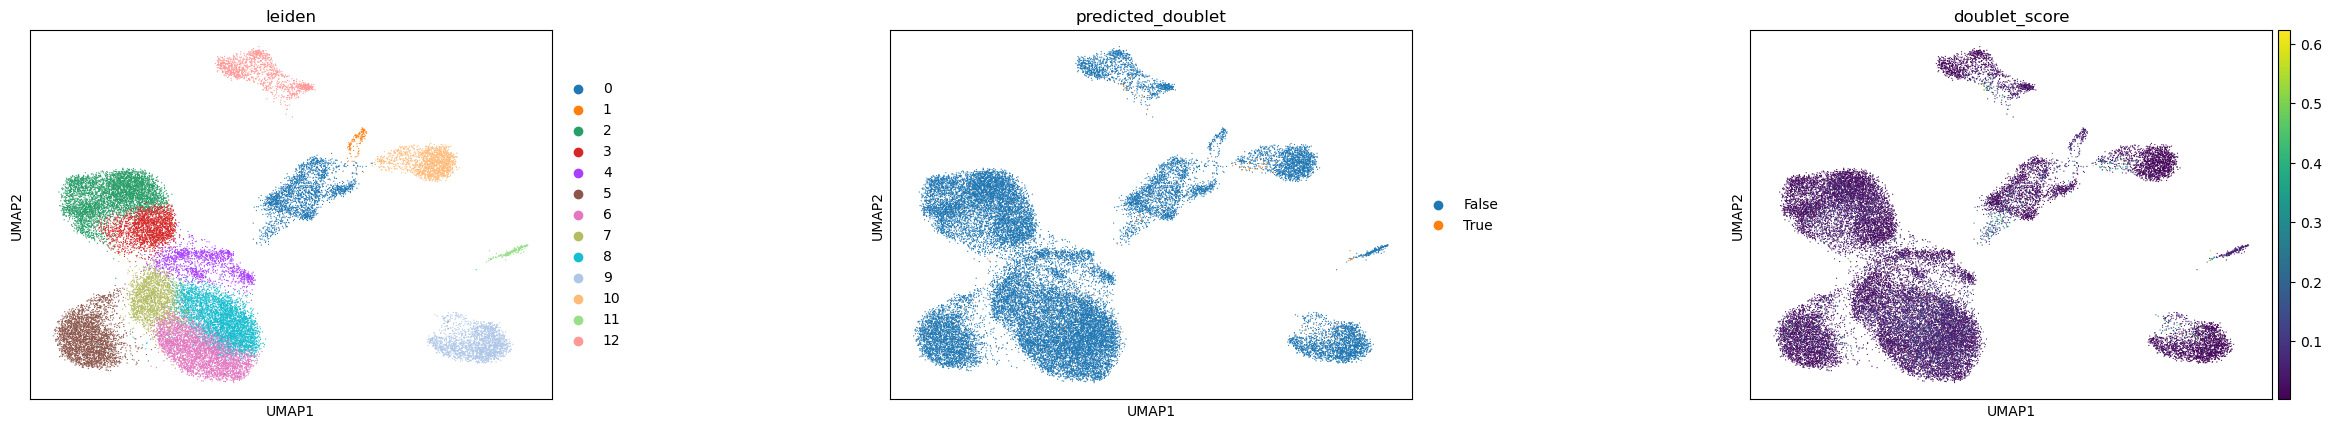

In [22]:
sc.pl.umap(
    adata,
    color=["leiden", "predicted_doublet", "doublet_score"],
    # increase horizontal space between panels
    wspace=0.5,
    size=3,
)

In [23]:
for res in [0.02, 0.5, 2.0]:
    sc.tl.leiden(
        adata, key_added=f"leiden_res_{res:4.2f}", resolution=res, flavor="igraph"
    )


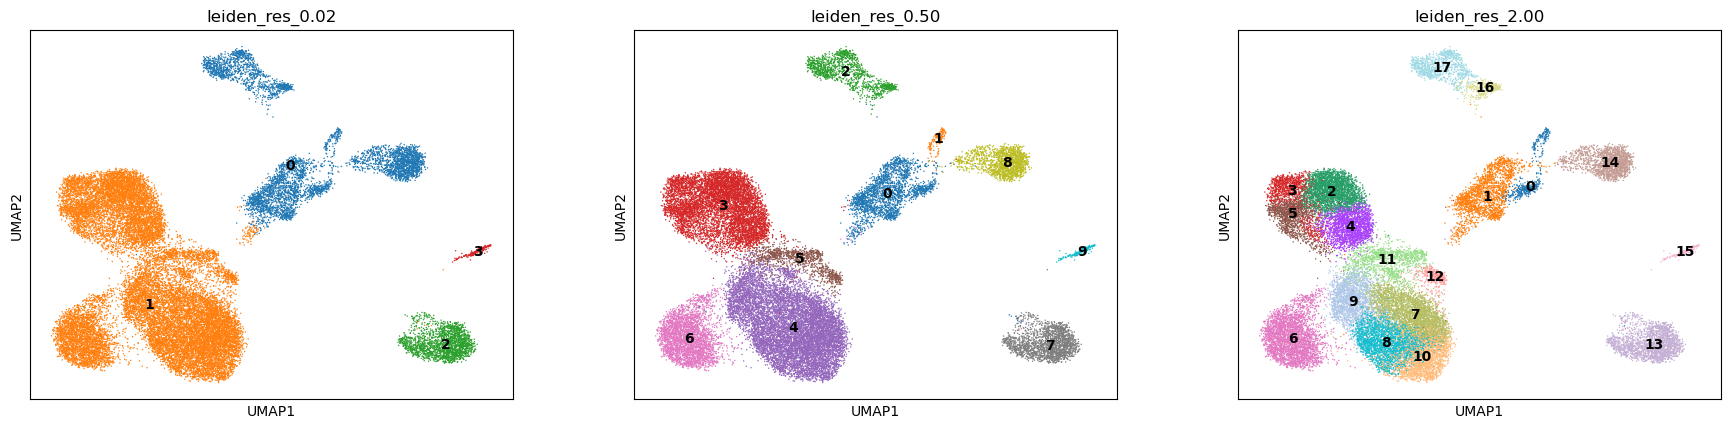

In [24]:
sc.pl.umap(
    adata,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_2.00"],
    legend_loc="on data",
)